In [1]:
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets
#%matplotlib inline #如果你使用用的是Jupyter Notebook的话请取消注释。
np.random.seed(1) #设置一个固定的随机种子，以保证接下来的步骤中我们的结果是一致的。

## 加载和参看数据集

'注: x.shape = (2,400)\n       y.shape = (1,400) 后面可能会转置\n       一共有400个数据，数据也可以不用通过调这个函数获得，我己经将其写入文件\n'

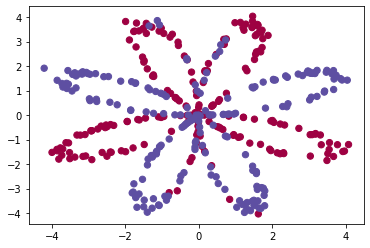

In [2]:
X,Y = load_planar_dataset()
# Visualize the data 可视化
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
'''注: x.shape = (2,400)
       y.shape = (1,400) 后面可能会转置
       一共有400个数据，数据也可以不用通过调这个函数获得，我己经将其写入文件
'''

## 定义神经网络结构

In [3]:
def lay_sizes(X, Y):
    '''
    :param X: 输入数据集
    :param Y: 输入的标签值
    '''
    n_x = X.shape[0] #输入层含有x的数目
    n_h = 4          #隐藏层神经元的数目
    n_y = Y.shape[0] #最后输出层对应的大小
    return (n_x, n_h, n_y)

## 初始化模型的参数
Initialize the model's parameters

In [4]:
def initialize_parameters(n_x, n_h, n_y):
    '''
    :param n_x: 同上 输入层节点数目
    :param n_h: 隐藏层节点数目
    :param n_y: 输出层节点数目
    :return: parameters 包含：
             W1 - 权重矩阵1，维度为(n_h,n_x) (4,2)
             b1 = 偏置矩阵1，维度为(n_h,1)   (4,1)
             W2 = 权重矩阵2，维度为(n_y,n_h) (1,4)
             b2 = 偏置矩阵1，维度为(n_y,1)   (1,1)
             注这里的 W，b 都是自己随机生成的
             numpy.random.randn()产生服从正态分布的随机数，会出现负值
             numpy.random.rand()产生从[ 0 , 1 ) [0,1)[0,1)之间的随机数，没有负值
             深度学习中的parameters是可能会有负值的，所以我们不使用numpy.random.rand()
    '''
    np.random.seed(2)
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))

    #使用断言确保我的数据格式是正确的
    assert(W1.shape == ( n_h , n_x ))
    assert(b1.shape == ( n_h , 1 ))
    assert(W2.shape == ( n_y , n_h ))
    assert(b2.shape == ( n_y , 1 ))

    parameters = {'W1' : W1,
                  'b1' : b1,
                  'W2' : W2,
                  'b2' : b2
                 }
    return parameters


## 前向传播

In [5]:
def forward_propagation(X, parameters):
    '''
    :param X:
    :param parameters:
    :return:  A2 - 使用sigmoid()函数计算的第二次激活后的数值
              cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型变量
    '''
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    #前向传播

    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)           #隐藏层经过激活函数
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)           #输出层经过激活函数
    cache = {'Z1' : Z1,
             'A1' : A1,
             'Z2' : Z2,
             'A2' : A2
            }
    return(A2, cache)

## 损失函数
交叉熵

In [6]:
def compute_cost(A2, Y, parameters):
    '''
    我这里沿用的是逻辑回归里面的损失函数
    如果y是1 yhat也是1(同y=0，yhat=0情况),那么这样损失函数就是最小的
    :param A2:使用sigmoid()函数计算的输出
    :param Y:最后的标签向量
    :param parameters:同上
    :return:cost
    注意：numpy中矩阵的点乘有两种方式  1. * ；2. np.multiply
    '''

    '''
    m = Y.shape[1]
    W1 = parameters['W1']
    W2 = parameters['W2']
    y_hat = A2
    first = Y * np.log(y_hat)
    second = (1-Y) * np.log(1-y_hat)
    cost = - np.sum(first + second)/m  #-->这里对所有样本的损失函数求和是为什么
    assert(isinstance(cost,float))
    print(cost)
    #返回所有样本损失函数的和，因为上面已经求了和
    return cost
    '''

    m = Y.shape[1] # number of example

    # Retrieve W1 and W2 from parameters
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters['W1']
    W2 = parameters['W2']
    ### END CODE HERE ###

    # Compute the cross-entropy cost
    ### START CODE HERE ### (≈ 2 lines of code)
    logprobs = np.multiply(np.log(A2 + 0.00000000001), Y) + np.multiply((1 - Y), np.log(1 - A2 + 0.00000000001))
    cost = - np.sum(logprobs) / m
    ### END CODE HERE ###

    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect.
                                # E.g., turns [[17]] into 17
    assert(isinstance(cost, float))

    return cost

## 反向传播

In [7]:
def backward_propagation(parameters, cache, X, Y):
    '''
    :param parameters:包含我们参数的一个字典类型的变量
    :param cache:字典，其中包括前向传播计算过的 Z1,A1,Z2,A2
    :param X:输入数据
    :param Y:labels标签
    :return:返回一个梯度字典
    '''

    m = X.shape[1]          #这里是横着的，所以用的不是第0维
    W1 = parameters['W1']
    W2 = parameters['W2']

    A1 = cache['A1']
    A2 = cache['A2']

    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))                           #后叉乘的目的是为了恢复Z1的行和列
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {'dW1' : dW1,
             'db1' : db1,
             'dW2' : dW2,
             'db2' : db2}
    return grads

## 更新参数

In [8]:
def update_parameters(parameters, grads, learning_rate=1.0):
    '''
    :param parameters:同上
    :param grads:同上
    :return: 更新之后的 parameters
    '''
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {'W1' : W1,
                  'b1' : b1,
                  'W2' : W2,
                  'b2' : b2}

    return parameters

## 整合上面的代码

In [9]:
def nn_model(X, Y, n_h, num_iterations=10000, print_cost=False):
    '''
    :param X:   dataSet
    :param Y:   labels
    :param n_h: hidden layer 的大小
    :param num_iterations: 迭代次数
    :param print_cost:     利用这个标签位，每迭代1000次打印 cost
    :return:    模型最后学习到的参数
    '''
    np.random.seed(3)
    n_x = lay_sizes(X, Y)[0]
    n_y = lay_sizes(X, Y)[2]

    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y, parameters)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)

    if print_cost and i % 1000 == 0:
        print('Cost after iteration {} : {}'.format(i, cost))

    return parameters

## 最终预测

In [10]:
def predict(parameters, X):
    '''
    我感觉学习不过是挖坑和填坑的过程
    :param parameters: 字典包含参数
    :param X:          (n_x, m)
    :return: parameters -- 我们模型的预测结果(red : 0/blue : 1)
    '''
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)          #对浮点数取整的函数
    return predictions

## 正式运行

[[  0.14937917  -9.35943636]
 [-10.33149161   3.14979223]
 [-10.51142972 -12.36418015]
 [  8.6840671   -9.61057471]]
-------------------
[[-0.04061479]
 [-0.37537515]
 [-0.04965999]
 [ 0.05527522]]
-------------------
[[-11.7866962    3.42320045   6.0527309   10.40347376]]
-------------------
[[-0.05868774]]
-------------------
*******************
[[0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

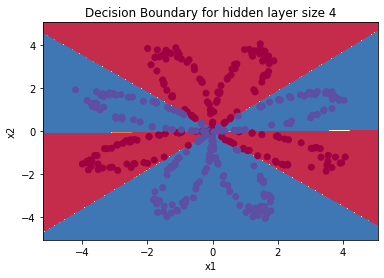

In [11]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)
print(parameters['W1'])
print('-------------------')
print(parameters['b1'])
print('-------------------')
print(parameters['W2'])
print('-------------------')
print(parameters['b2'])
print('-------------------')
predictions = predict(parameters, X)
print('*******************')
print(predictions)
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, predictions)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [12]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%
